In [1]:
!pip install minepy
!pip install scikit-optimize
!pip install barplots
!pip install cache_decorator
!pip install extra_keras_metrics
!pip install epigenomic_dataset
!pip install ucsc_genomes_downloader
!pip install keras_bed_sequence
!pip install boruta
!pip install seaborn
!pip install mine

     |████████████████████████████████| 495 kB 7.9 MB/s 
  Created wheel for minepy: filename=minepy-1.2.5-cp37-cp37m-linux_x86_64.whl size=177531 sha256=5313794fa57519df8f84db0add8e63cbc83e4eabfaa59b7cb1552ad8b7dc854d
  Stored in directory: /root/.cache/pip/wheels/d1/ea/d7/fabbfa6e294adcbc43dabca0e0158dafdd36051246992c7311
Successfully built minepy
     |████████████████████████████████| 101 kB 4.3 MB/s 
  Created wheel for barplots: filename=barplots-1.1.11-py3-none-any.whl size=17877 sha256=bdc72b3390bf0005d2eea3fd81b79b7bc4a7f58e2d6dc88d485db9cc32388fd4
  Stored in directory: /root/.cache/pip/wheels/2a/53/e4/1c71fe6cb782f2f43b23872deea5369ad81c11118361558728
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.26-py3-none-any.whl size=7612 sha256=b5c61ef5067a2e8836a7cb3e6baf40331faacbd9261d520b2683716c385df1d3
  Stored in directory: /root/.cache/pip/wheels/15/65/34/2e11a0da3cf6f112da5c402e01c454be619ff85a0fb38b3018
  Created wheel for compress-json: filename=comp

In [33]:
from epigenomic_dataset import load_epigenomes, active_enhancers_vs_inactive_enhancers, active_promoters_vs_inactive_promoters
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from cache_decorator import Cache
from tqdm.keras import TqdmCallback
from multiprocessing import cpu_count
from ucsc_genomes_downloader import Genome
from barplots import barplots
from keras_bed_sequence import BedSequence
from keras_mixed_sequence import MixedSequence, VectorSequence
import matplotlib.pyplot as plt # A standard plotting library
import seaborn as sns

## Data retrieval and Pre-Processing.

In [2]:
import itertools

region_threshold = [["promoters", "enhancers"],
 [1.0, 0.5]
]

dataset_list = []
for element in itertools.product(*region_threshold):
  # Retrieving the data
  X, y = load_epigenomes(
      cell_line = "H1",
      dataset = "fantom",
      region = element[0],
      window_size = 256,
      root = "datasets", # Path where to download data,
      binarize = True,
      min_active_tpm_value = element[1],
      max_inactive_tpm_value = element[1]
  )

  # Creating the imputer
  imputer = KNNImputer()
  # Creating the scaler
  scaler = RobustScaler()

  # Imputing and scaling the data
  X = pd.DataFrame(
      scaler.fit_transform(
          imputer.fit_transform(X)
      ),
      index=X.index,
      columns=X.columns
  )

  dataset_list.append((element, X, y))

### Visualisation of the data by PCA decomposition

In [56]:
from sklearn.decomposition import PCA

def pca(x:np.ndarray, n_components:int=2)->np.ndarray:
    return PCA(n_components=n_components, random_state=42).fit_transform(x)

In [ ]:
from sklearn.decomposition import PCA

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(25, 5))

for dataset, axis in zip(dataset_list, axes.flatten()):
  colors = np.array([
      "tab:blue",
      "tab:orange",
  ])

  xseries = []
  yseries = []
  for example in pca(dataset[1]):
      xseries.append(example[0])
      yseries.append(example[1])

  tcolors = []
  for color in colors[dataset[2].values.astype(int)]:
      tcolors.append(color[0])

  axis.scatter(xseries, yseries, s=1, c=tcolors)
  axis.set_title(f"Inactive {dataset[0][0]} vs Active {dataset[0][0]} (>= {dataset[0][1]})")
plt.show()

Top 5 different features on promoters epigenomic dataset.
Top 5 different features on promoters epigenomic dataset.
Top 5 different features on enhancers epigenomic dataset.
Top 5 different features on enhancers epigenomic dataset.


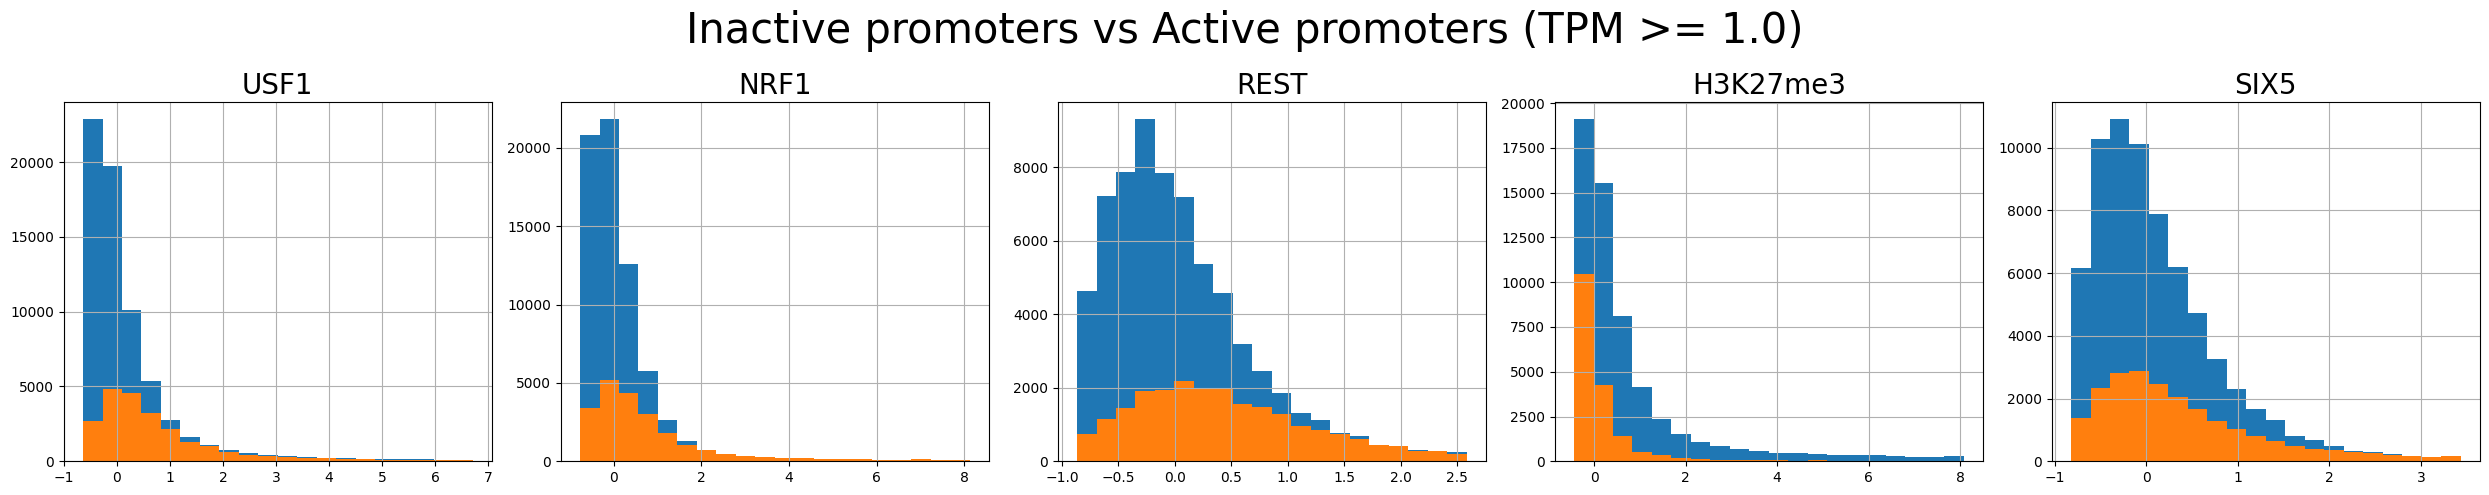

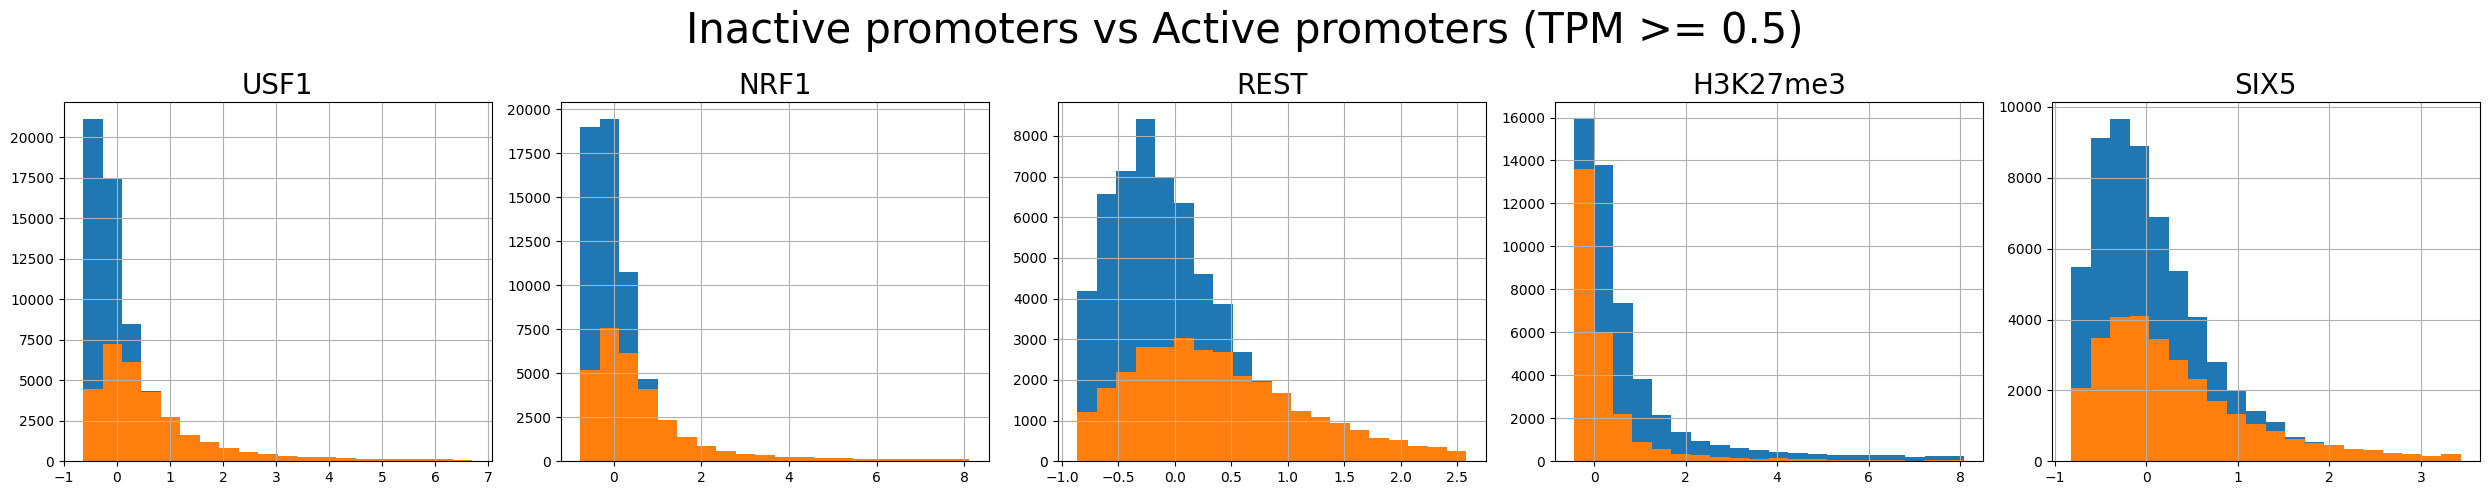

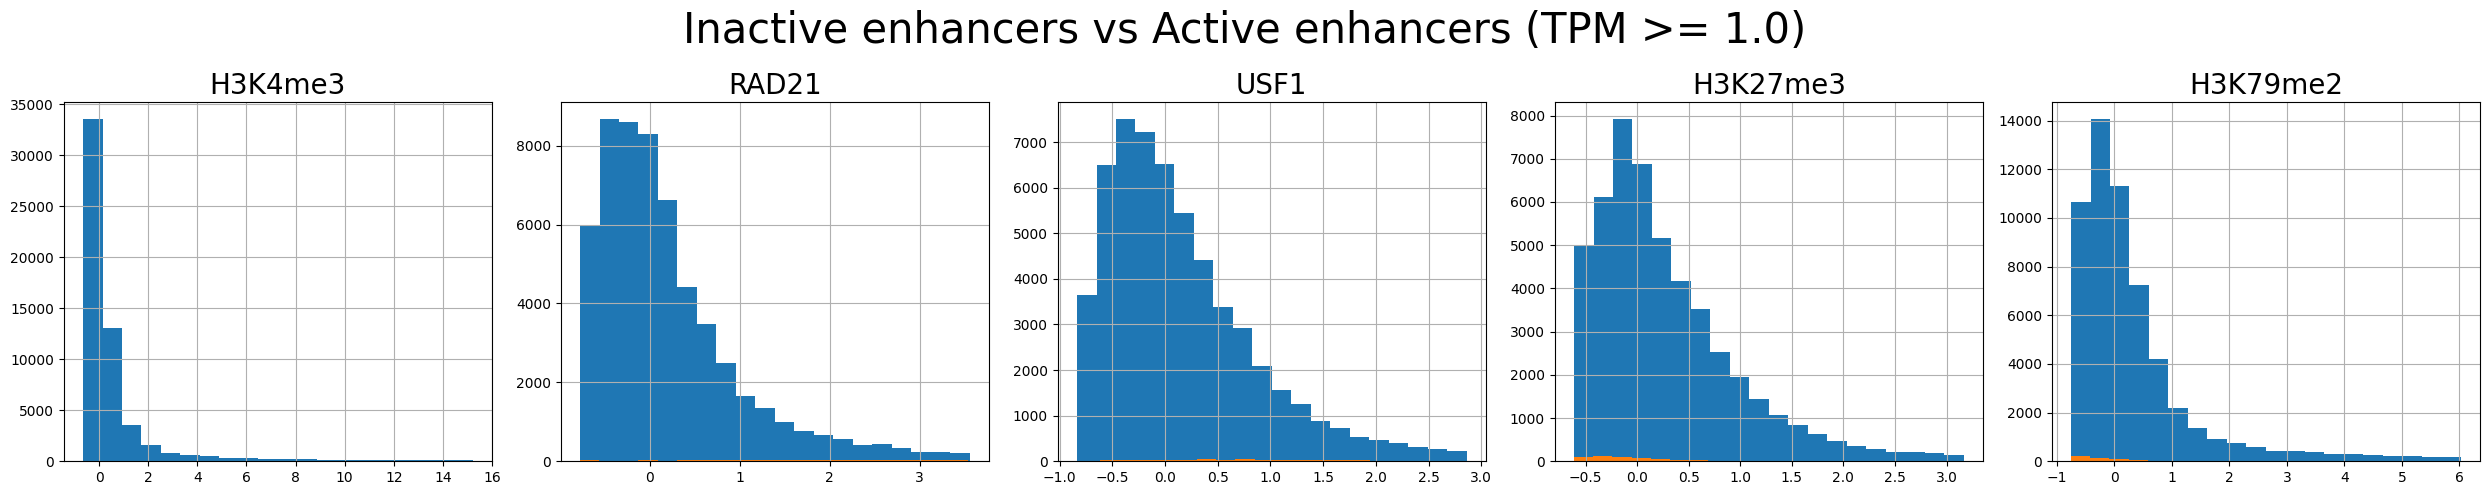

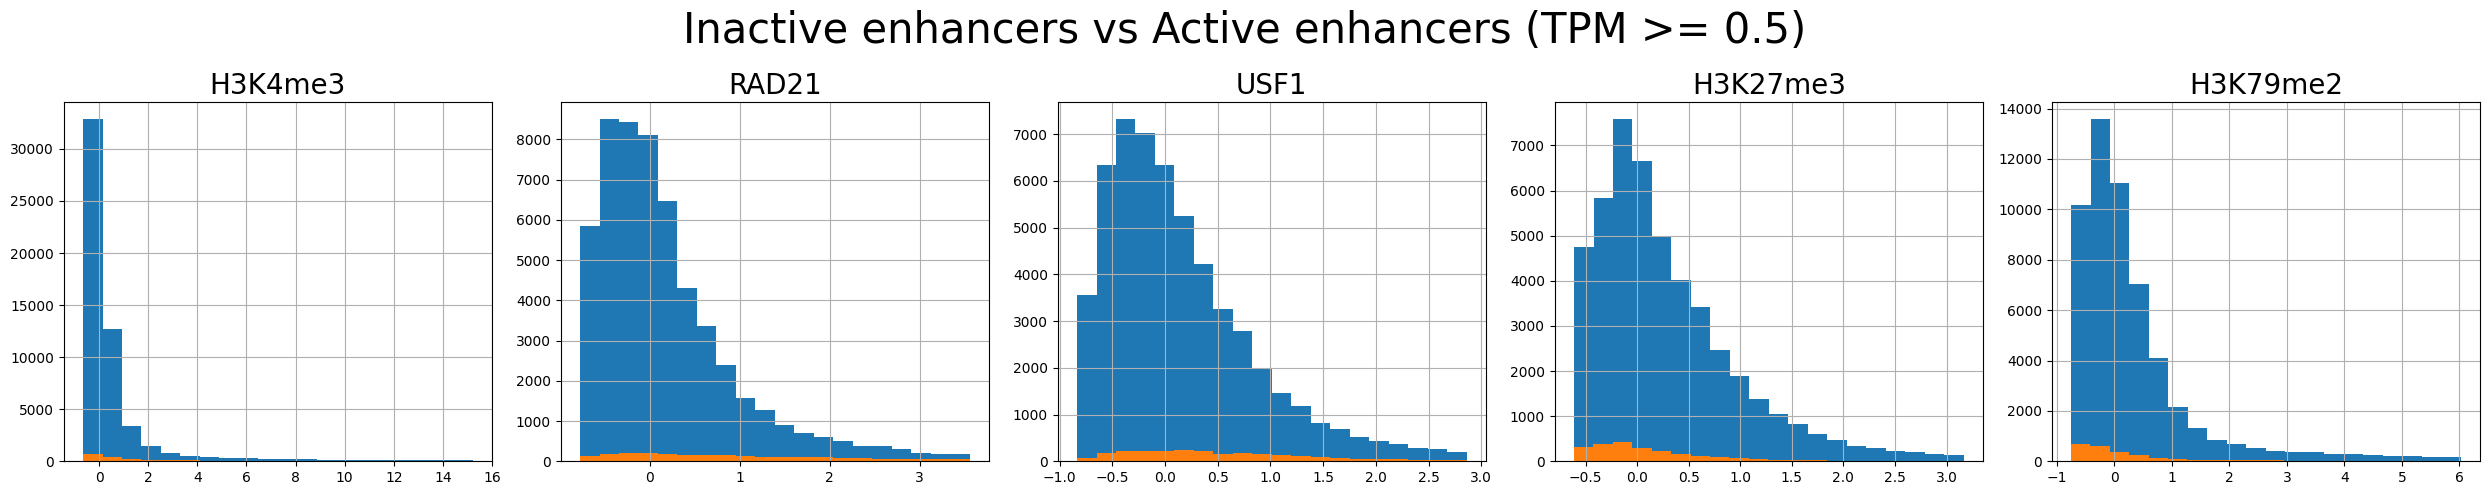

In [52]:
from sklearn.metrics.pairwise import euclidean_distances

def get_top_most_different(dist, n:int):
    return np.argsort(-np.mean(dist, axis=1).flatten())[:n]

top_number = 5

for dataset in dataset_list:
    X = dataset[1]
    y = dataset[2]
    dist = euclidean_distances(X.T)
    most_distance_columns_indices = get_top_most_different(dist, top_number)
    columns = X.columns[most_distance_columns_indices]
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))
    print(f"Top {top_number} different features on {dataset[0][0]} epigenomic dataset.")
    for column, axis in zip(columns, axes.flatten()):
        head, tail = X[column].quantile([0.05, 0.95]).values.ravel()

        mask = ((X[column] < tail) & (X[column] > head)).values

        cleared_X = X[column][mask]
        cleared_y = y.values.ravel()[mask]

        cleared_X[cleared_y==0].hist(ax=axis, bins=20)
        cleared_X[cleared_y==1].hist(ax=axis, bins=20)

        axis.set_title(column, fontsize=20)
    fig.suptitle(f"Inactive {dataset[0][0]} vs Active {dataset[0][0]} (TPM >= {dataset[0][1]})", fontsize=30)
    fig.tight_layout()

plt.show()

In [ ]:
#@title DNA sequence visualization


In [37]:
genome = Genome("hg38")

Loading chromosomes for genome hg38:   0%|          | 0/25 [00:00<?, ?it/s]

In [51]:
import itertools
from ucsc_genomes_downloader import Genome



region_threshold = [
                    ["promoters", "enhancers"],
                    [1.0, 0.5]
                    ]

dataset_list = []
cell_line = "H1"
for element in itertools.product(*region_threshold):
  # Retrieving the data
  if element[0] == "enhancers":
    X, y = active_enhancers_vs_inactive_enhancers(
        cell_line=cell_line,
        binarize=True,
        min_active_tpm_value = element[1],
        max_inactive_tpm_value = element[1]
      )
  else:
    X, y = active_promoters_vs_inactive_promoters(
      cell_line=cell_line,
      binarize=True,
      min_active_tpm_value = element[1],
      max_inactive_tpm_value = element[1]
    )

  X = X.reset_index()
  bed = X[X.columns[:5]]

  dataset_list.append((element, bed, y))

In [52]:
def build_sequence(
    X: pd.DataFrame,
    y: np.ndarray,
    genome: Genome,
    batch_size: int
) -> MixedSequence:
    return MixedSequence(
        x=BedSequence(
            genome,
            X,
            batch_size=batch_size,
        ),
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

In [53]:
from sklearn.decomposition import FactorAnalysis

def mfa(x:np.ndarray, n_components:int=2)->np.ndarray:
    return FactorAnalysis(n_components=n_components, random_state=42).fit_transform(x)

Rendering sequence.:   0%|          | 0/1 [00:00<?, ?it/s]

Rendering sequence.:   0%|          | 0/1 [00:00<?, ?it/s]

Rendering sequence.:   0%|          | 0/1 [00:00<?, ?it/s]

Rendering sequence.:   0%|          | 0/1 [00:00<?, ?it/s]

Rendering sequence.:   0%|          | 0/1 [00:00<?, ?it/s]

Rendering sequence.:   0%|          | 0/1 [00:00<?, ?it/s]

Rendering sequence.:   0%|          | 0/1 [00:00<?, ?it/s]

Rendering sequence.:   0%|          | 0/1 [00:00<?, ?it/s]

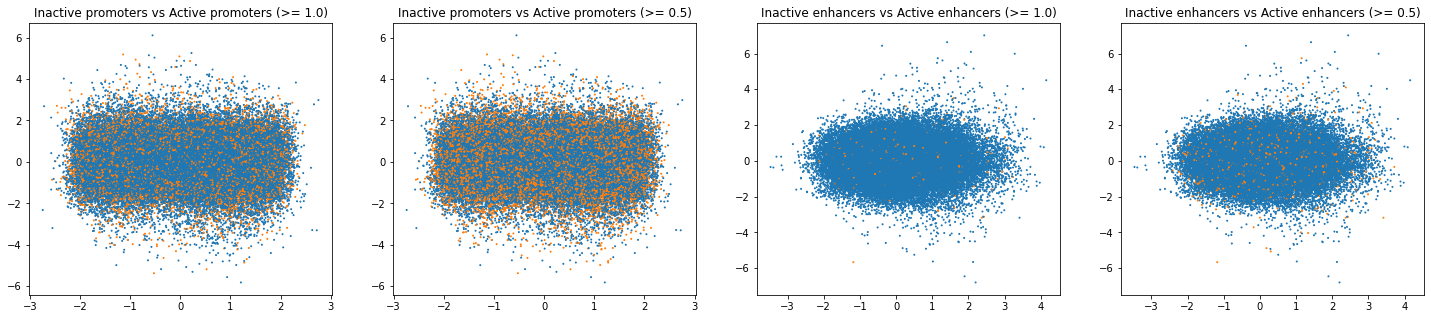

In [54]:
from sklearn.decomposition import FactorAnalysis

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(25, 5))

for dataset, axis in zip(dataset_list, axes.flatten()):
  colors = np.array([
      "tab:blue",
      "tab:orange",
  ])

  train_sequence = build_sequence(dataset[1], dataset[2].values, genome, batch_size=len(dataset[1]))
  X = train_sequence.rasterize()[0].reshape(-1, 256*4).astype(int)

  xseries = []
  yseries = []
  for example in mfa(X):
        xseries.append(example[0])
        yseries.append(example[1])

  tcolors = []
  for color in colors[dataset[2].values.astype(int)]:
      tcolors.append(color[0])

  axis.scatter(xseries, yseries, s=1, c=tcolors)
  axis.set_title(f"Inactive {dataset[0][0]} vs Active {dataset[0][0]} (>= {dataset[0][1]})")

plt.show()

Running Pearson test for promoters:   0%|          | 0/58 [00:00<?, ?it/s]

Most 5  correlated features with Pearson Correlation method:
(0.9332611395103332, 'POLR2A', 'POLR2AphosphoS5', 0.0)
(0.8965576515651833, 'H3K27ac', 'H3K9ac', 0.0)
(0.8939524166139503, 'TAF1', 'POLR2A', 0.0)
(0.8530017664983799, 'SUZ12', 'RNF2', 0.0)
(0.8393124628935497, 'POLR2A', 'TAF7', 0.0)
Most 5  uncorrelated features with Pearson Correlation method:
(-0.0015382323311993779, 'GABPA', 'H3K27me3', 0.6268704150526146)
(-0.0014065384838712143, 'ATF3', 'RNF2', 0.6566692365428313)
(0.0008631436395406854, 'GTF2F1', 'RNF2', 0.7850191301472157)
(-0.000550956683984365, 'H3K27me3', 'BACH1', 0.8617696317363106)
(0.000531063881593108, 'H2AFZ', 'POLR2AphosphoS5', 0.8667130052687623)


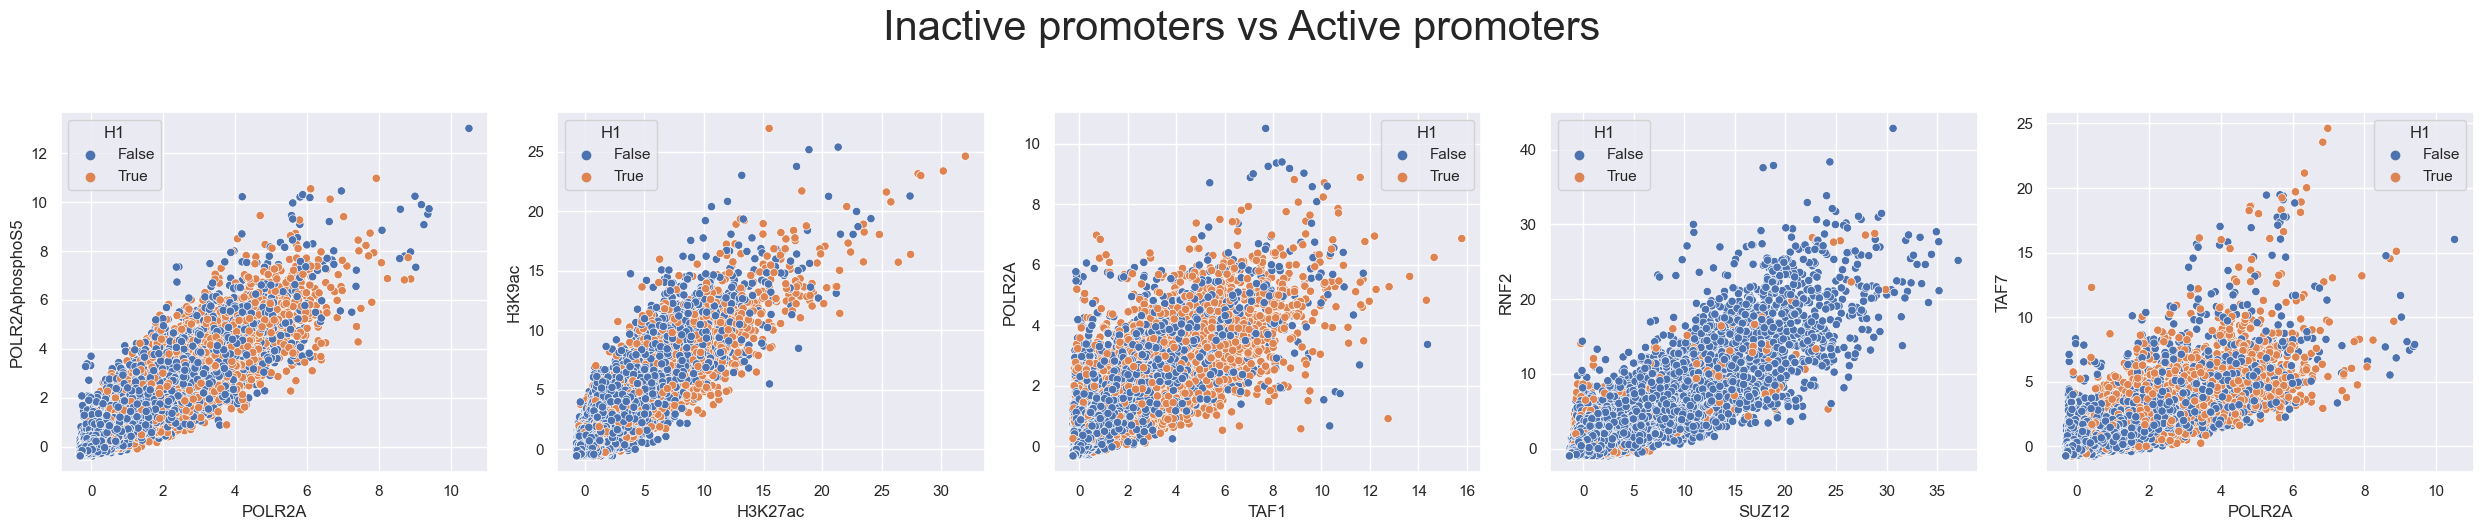

Running Pearson test for promoters:   0%|          | 0/58 [00:00<?, ?it/s]

Most 5  correlated features with Pearson Correlation method:
(0.9332611395103332, 'POLR2A', 'POLR2AphosphoS5', 0.0)
(0.8965576515651833, 'H3K27ac', 'H3K9ac', 0.0)
(0.8939524166139503, 'TAF1', 'POLR2A', 0.0)
(0.8530017664983799, 'SUZ12', 'RNF2', 0.0)
(0.8393124628935497, 'POLR2A', 'TAF7', 0.0)
Most 5  uncorrelated features with Pearson Correlation method:
(-0.0015382323311993779, 'GABPA', 'H3K27me3', 0.6268704150526146)
(-0.0014065384838712143, 'ATF3', 'RNF2', 0.6566692365428313)
(0.0008631436395406854, 'GTF2F1', 'RNF2', 0.7850191301472157)
(-0.000550956683984365, 'H3K27me3', 'BACH1', 0.8617696317363106)
(0.000531063881593108, 'H2AFZ', 'POLR2AphosphoS5', 0.8667130052687623)


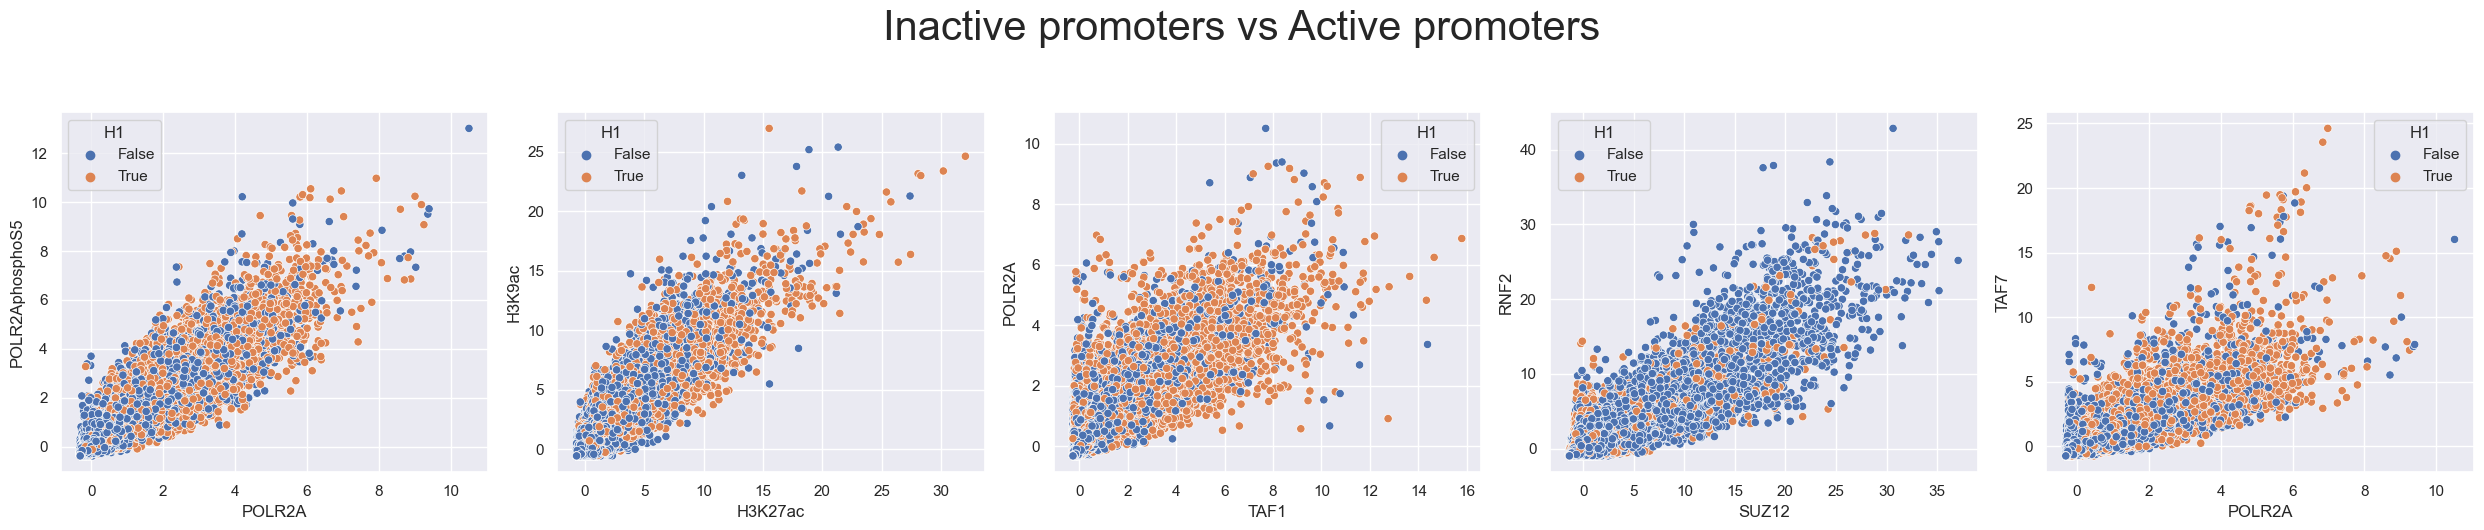

Running Pearson test for promoters:   0%|          | 0/58 [00:00<?, ?it/s]

Most 5  correlated features with Pearson Correlation method:
(0.8869152391081401, 'POLR2A', 'POLR2AphosphoS5', 0.0)
(0.8780161221411962, 'H3K4me3', 'H3K4me2', 0.0)
(0.8583613081608321, 'CTCF', 'RAD21', 0.0)
(0.8209316138662461, 'SUZ12', 'RNF2', 0.0)
(0.8140772687226685, 'SUZ12', 'H3K27me3', 0.0)
Most 5  uncorrelated features with Pearson Correlation method:
(-0.0009963821559394307, 'H3K9me3', 'H4K20me1', 0.8020846522486882)
(0.000839736942378525, 'H3K79me2', 'REST', 0.832696587030786)
(0.0006135472995460669, 'TAF1', 'H3K27me3', 0.8773384632415357)
(-0.0005586583148192978, 'H3K36me3', 'H3K9ac', 0.8882363762304071)
(-0.0003427320406239297, 'JUND', 'H3K79me2', 0.9312933447053859)


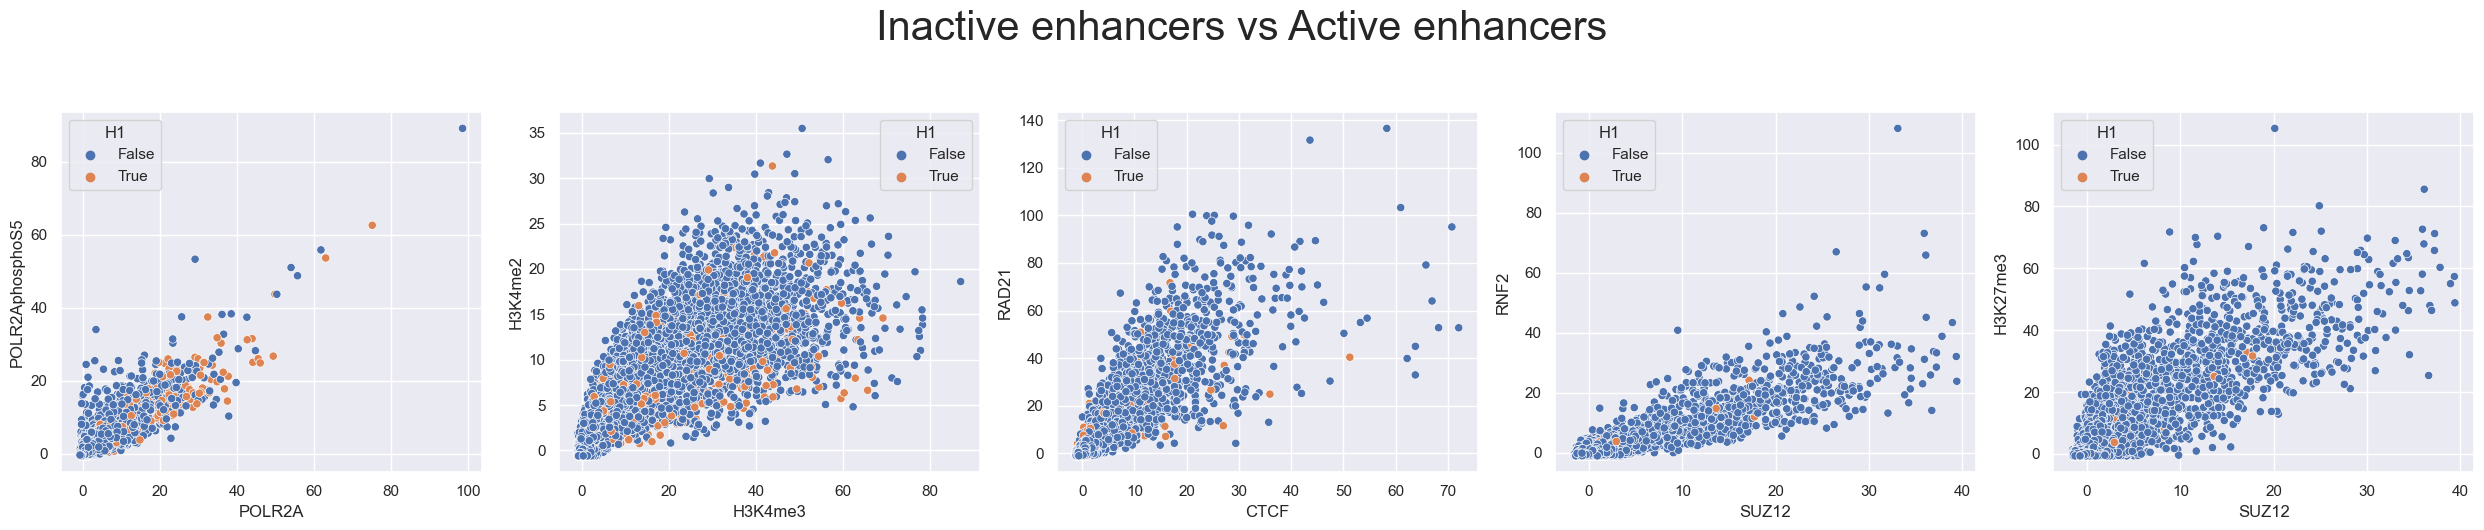

Running Pearson test for promoters:   0%|          | 0/58 [00:00<?, ?it/s]

Most 5  correlated features with Pearson Correlation method:
(0.8869152391081401, 'POLR2A', 'POLR2AphosphoS5', 0.0)
(0.8780161221411962, 'H3K4me3', 'H3K4me2', 0.0)
(0.8583613081608321, 'CTCF', 'RAD21', 0.0)
(0.8209316138662461, 'SUZ12', 'RNF2', 0.0)
(0.8140772687226685, 'SUZ12', 'H3K27me3', 0.0)
Most 5  uncorrelated features with Pearson Correlation method:
(-0.0009963821559394307, 'H3K9me3', 'H4K20me1', 0.8020846522486882)
(0.000839736942378525, 'H3K79me2', 'REST', 0.832696587030786)
(0.0006135472995460669, 'TAF1', 'H3K27me3', 0.8773384632415357)
(-0.0005586583148192978, 'H3K36me3', 'H3K9ac', 0.8882363762304071)
(-0.0003427320406239297, 'JUND', 'H3K79me2', 0.9312933447053859)


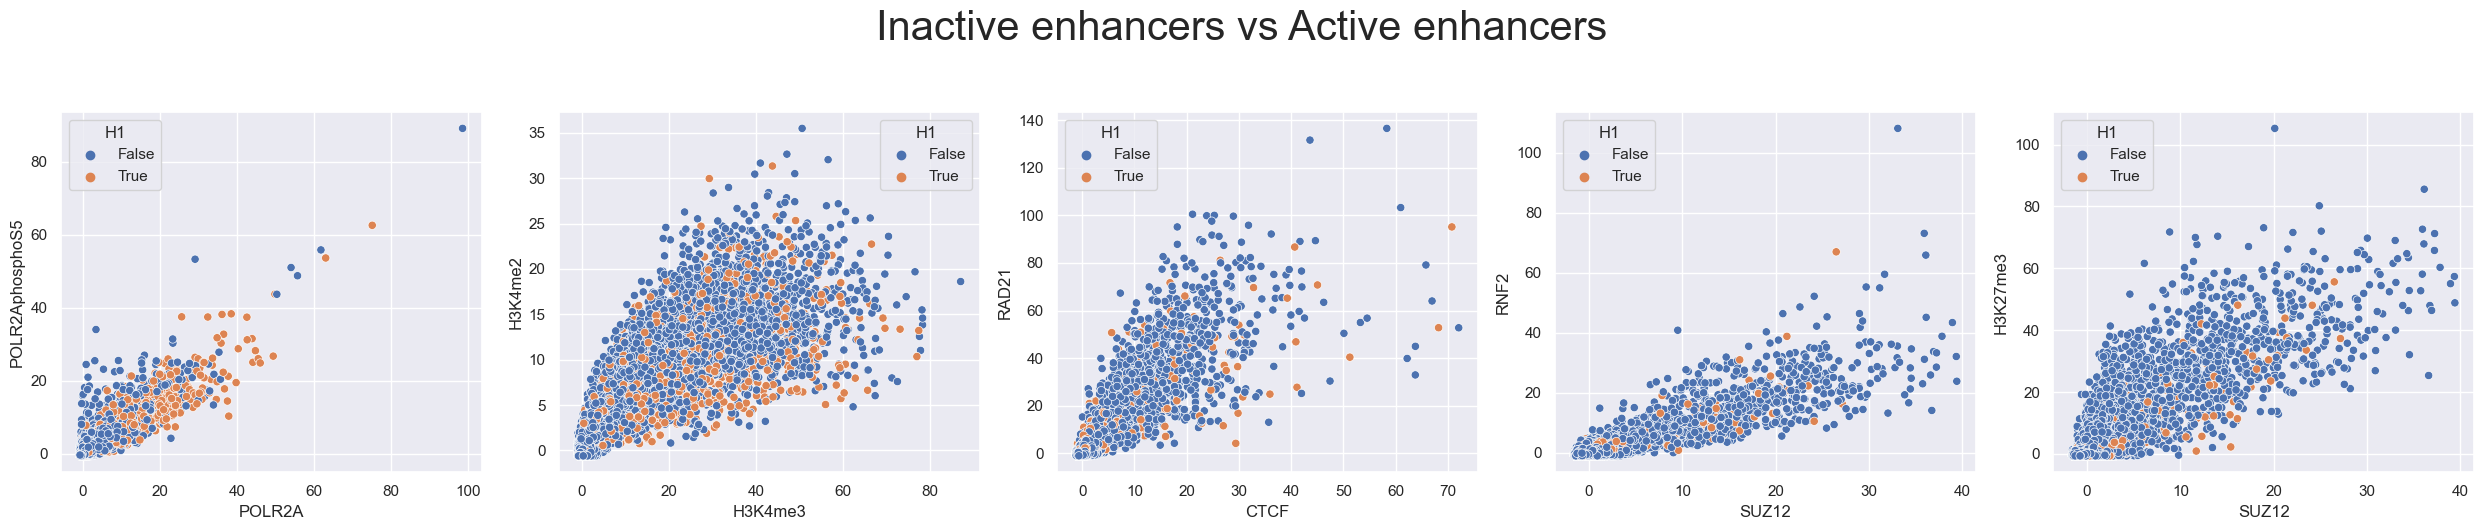

In [55]:
from scipy.stats import pearsonr
from scipy.stats import entropy

p_value_threshold = 0.01
correlation_threshold = 0.95

extremely_correlated =  set()
n_top_scores = 5

for dataset, axis in zip(dataset_list, axes.flatten()):
    X = dataset[1]
    y = dataset[2]
    scores = []
    for i, column in tqdm(
        enumerate(X.columns),
        total=len(X.columns), desc=f"Running Pearson test for promoters", dynamic_ncols=True, leave=False):

        for feature in X.columns[i+1:]:
            correlation, p_value = pearsonr(X[column].values.ravel(), X[feature].values.ravel())

            scores.append((correlation, column, feature, p_value))
            if p_value < p_value_threshold and correlation > correlation_threshold:
                if entropy(X[column]) > entropy(X[feature]):
                    extremely_correlated.add(feature)
                else:
                    extremely_correlated.add(column)

    scores = sorted(scores, key=lambda x: np.abs(x[0]), reverse=True)
    print("Most", str(n_top_scores), " correlated features with Pearson Correlation method:")
    n = [print(score) for score in scores[:n_top_scores]] 
    print("Most", str(n_top_scores), " uncorrelated features with Pearson Correlation method:")
    n = [print(score) for score in scores[-n_top_scores:]]

    top_scores = scores[:n_top_scores]
    data = pd.concat([X, y], axis = 1)
    sns.set(rc={'figure.figsize':(25,5)})

    fig, axs = plt.subplots(ncols=n_top_scores)
    i = 0
    for i, score in enumerate(top_scores):
      sns.scatterplot(x = score[1], y = score[2], data = data, hue=y.columns[0],  ax=axs[i])

    fig.suptitle(f'Inactive {dataset[0][0]} vs Active {dataset[0][0]}', verticalalignment = "bottom", fontsize=30)
    plt.tight_layout()
    plt.show()

In [6]:
#@title Visualisation of the performances for each task and model


In [8]:
from scipy.stats import wilcoxon
def wilcoxon_test(all_performance, p_value_threshold = 0.01):
  for outer_model in all_performance.model_name.unique():
      outer_model_performance = all_performance[
          (all_performance.model_name == outer_model) &
          (all_performance.run_type == "test")]
      for model in all_performance.model_name.unique():
          if outer_model >= model:
              continue
          model_performance = all_performance[
              (all_performance.model_name == model) &
              (all_performance.run_type == "test") 
          ]

          for metric in ("AUPRC", "AUROC", "accuracy"):
              outer, inner = outer_model_performance[metric], model_performance[metric]
              _, p_value = wilcoxon(outer, inner)
              if p_value < p_value_threshold:
                  if outer.mean() > inner.mean():
                      best_model, worse_model = outer_model, model
                  else:
                      best_model, worse_model = model, outer_model
                  print("The model {} outperforms the model {} with p-value {} on metric {}.".format(
                      best_model,
                      worse_model,
                      p_value,
                      metric
                  ))
              else:
                  print("The model {} is statistially indistinguishiable {} with p-value {} on metric {}.".format(
                      outer_model,
                      model,
                      p_value,
                      metric
                  ))

In [12]:
all_performance_list=[]
fold = "performances"
for dataset in dataset_list:
  all_performance = pd.read_csv(f"{fold}//all_performances_{dataset[0][0]}_{dataset[0][1]}_mmnn.csv")
  all_performance_ffnn = pd.read_csv(f"{fold}//all_performances_{dataset[0][0]}_{dataset[0][1]}_ffnn.csv")
  all_performance_ffnn = all_performance_ffnn[all_performance_ffnn["use_feature_selection"] == False]
  all_performance_ffnn = all_performance_ffnn.rename(columns={'Accuracy': 'accuracy'})

  all_performance_ccnn = pd.read_csv(f"{fold}//all_performances_{dataset[0][0]}_{dataset[0][1]}_cnn.csv")

  all_performance = all_performance.append(all_performance_ffnn)
  all_performance = all_performance.append(all_performance_ccnn)
  all_performance = all_performance.filter(items=['model_name', 'run_type', 'accuracy', 'AUROC', 'AUPRC'])

  all_performance_list.append({(dataset[0][0], dataset[0][1]) : all_performance})


promoters 1.0


accuracy     AUROC     AUPRC
model_name run_type                              
CNN        test      0.746594  0.750162  0.456269
           train     0.753285  0.830442  0.551335
FFNN       test      0.810207  0.858754  0.647538
           train     0.828866  0.883889  0.713854
MMNN       test      0.813215  0.862255  0.658438
           train     0.827513  0.878657  0.704160

The model FFNN is statistially indistinguishiable MMNN with p-value 0.016604878103722735 on metric AUPRC.
The model FFNN is statistially indistinguishiable MMNN with p-value 0.13941397332153205 on metric AUROC.
The model FFNN is statistially indistinguishiable MMNN with p-value 0.09260069782067576 on metric accuracy.
The model MMNN outperforms the model CNN with p-value 0.005062032126267864 on metric AUPRC.
The model MMNN outperforms the model CNN with p-value 0.005062032126267864 on metric AUROC.
The model MMNN outperforms the model CNN with p-value 0.005062032126267864 on metric accuracy.
The model FFNN outperforms the model CNN with p-value 0.005062032126267864 on metric AUPRC.
The model FFNN outperforms the model CNN with p-value 0.005062032126267864 on metric AUROC.
The model FFNN outperforms the model CNN with p-value 0.005062032126267864 on metric accuracy.
performance_enhancers_0.5.jpeg


Rendering barplots:   0%|          | 0/3 [00:00<?, ?it/s]

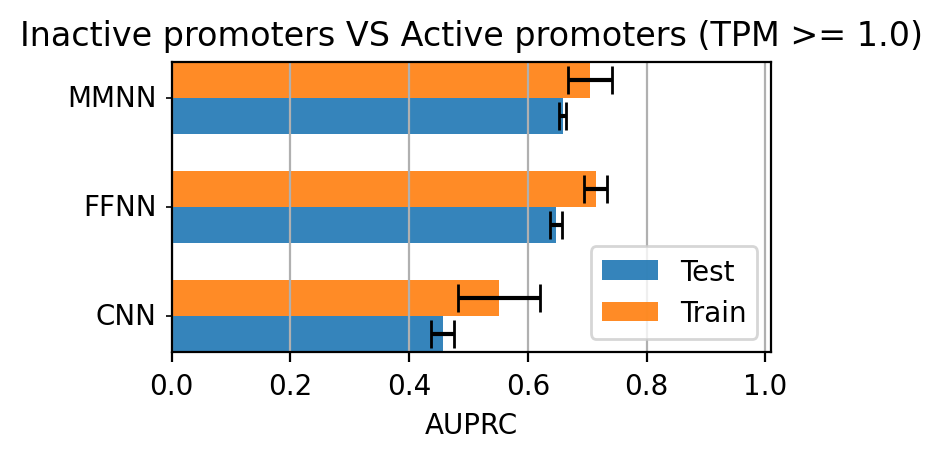

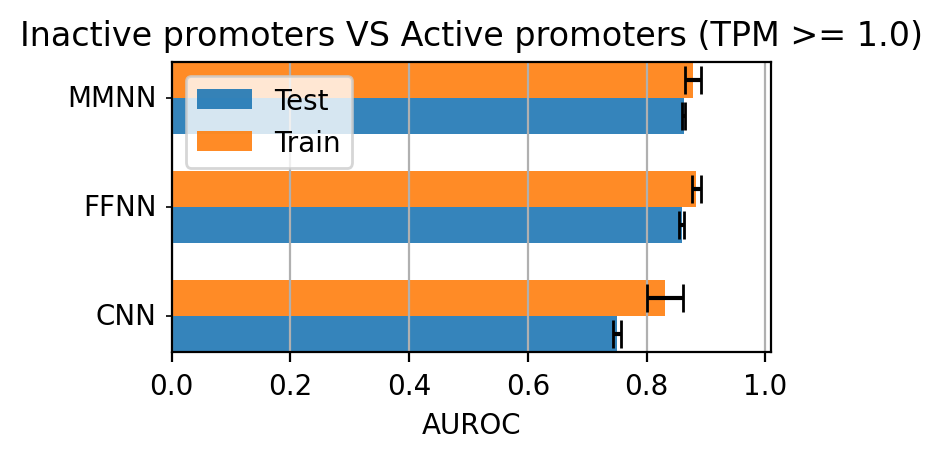

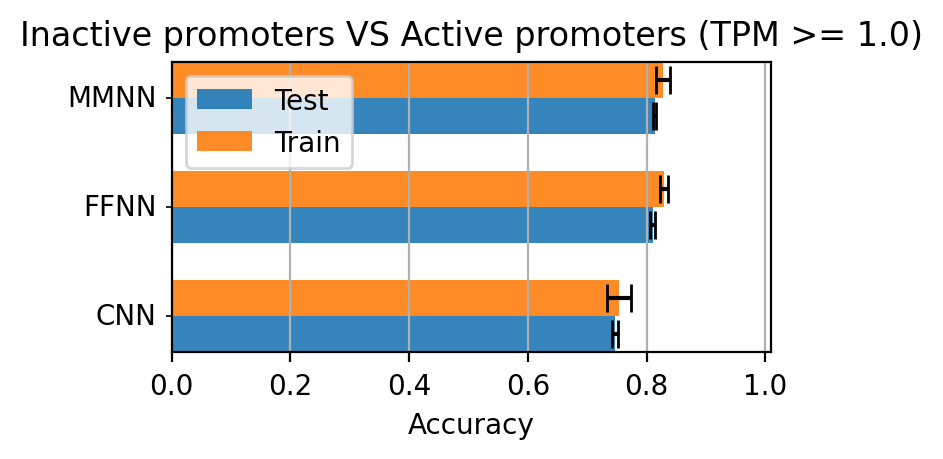

promoters 0.5


accuracy     AUROC     AUPRC
model_name run_type                              
CNN        test      0.707113  0.751812  0.594137
           train     0.757343  0.836378  0.716111
FFNN       test      0.788517  0.852089  0.732688
           train     0.799841  0.866175  0.771065
MMNN       test      0.787651  0.850492  0.738961
           train     0.816465  0.884665  0.803130

The model MMNN outperforms the model FFNN with p-value 0.005062032126267864 on metric AUPRC.
The model FFNN is statistially indistinguishiable MMNN with p-value 0.13941397332153205 on metric AUROC.
The model FFNN is statistially indistinguishiable MMNN with p-value 0.3862707203664827 on metric accuracy.
The model MMNN outperforms the model CNN with p-value 0.005062032126267864 on metric AUPRC.
The model MMNN outperforms the model CNN with p-value 0.005062032126267864 on metric AUROC.
The model MMNN outperforms the model CNN with p-value 0.005062032126267864 on metric accuracy.
The model FFNN outperforms the model CNN with p-value 0.005062032126267864 on metric AUPRC.
The model FFNN outperforms the model CNN with p-value 0.005062032126267864 on metric AUROC.
The model FFNN outperforms the model CNN with p-value 0.005062032126267864 on metric accuracy.
performance_enhancers_0.5.jpeg


Rendering barplots:   0%|          | 0/3 [00:00<?, ?it/s]

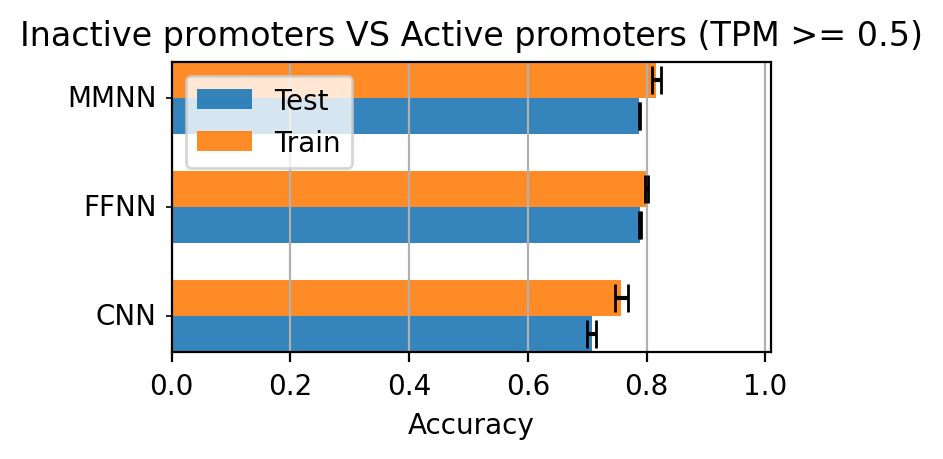

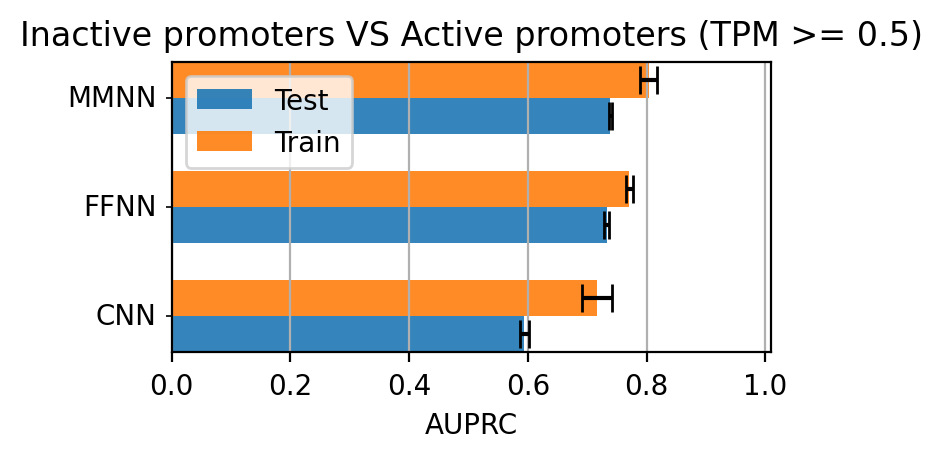

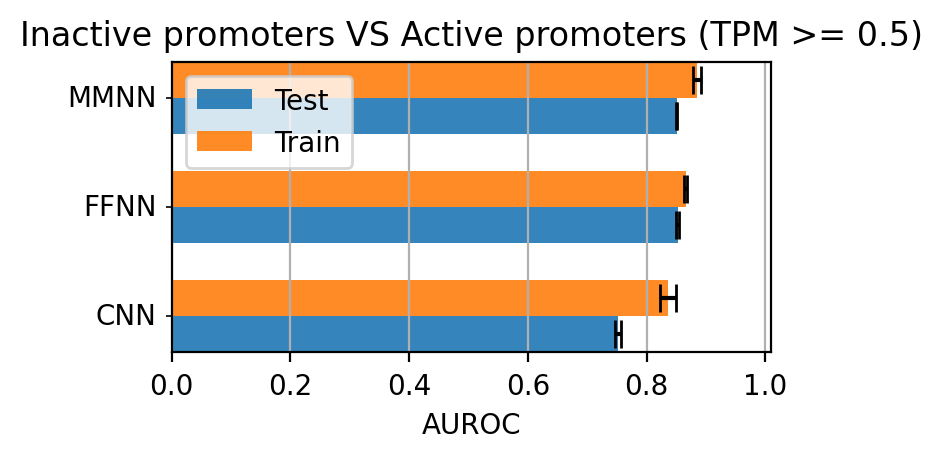

enhancers 1.0


accuracy     AUROC     AUPRC
model_name run_type                              
CNN        test      0.988670  0.695657  0.070072
           train     0.988787  0.955051  0.461692
FFNN       test      0.988702  0.919148  0.209884
           train     0.988702  0.957809  0.238087
MMNN       test      0.987872  0.841315  0.229947
           train     0.994606  0.990378  0.833100

The model FFNN is statistially indistinguishiable MMNN with p-value 0.09260069782067576 on metric AUPRC.
The model FFNN outperforms the model MMNN with p-value 0.005062032126267864 on metric AUROC.
The model FFNN is statistially indistinguishiable MMNN with p-value 0.012458141993823996 on metric accuracy.
The model MMNN outperforms the model CNN with p-value 0.005062032126267864 on metric AUPRC.
The model MMNN outperforms the model CNN with p-value 0.005062032126267864 on metric AUROC.
The model CNN is statistially indistinguishiable MMNN with p-value 0.020767228881243147 on metric accuracy.
The model FFNN outperforms the model CNN with p-value 0.005062032126267864 on metric AUPRC.
The model FFNN outperforms the model CNN with p-value 0.005062032126267864 on metric AUROC.
The model FFNN outperforms the model CNN with p-value 0.003580327522366853 on metric accuracy.
performance_enhancers_0.5.jpeg


E:\anaconda\envs\cazzo_culo\lib\site-packages\scipy\stats\morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


Rendering barplots:   0%|          | 0/3 [00:00<?, ?it/s]

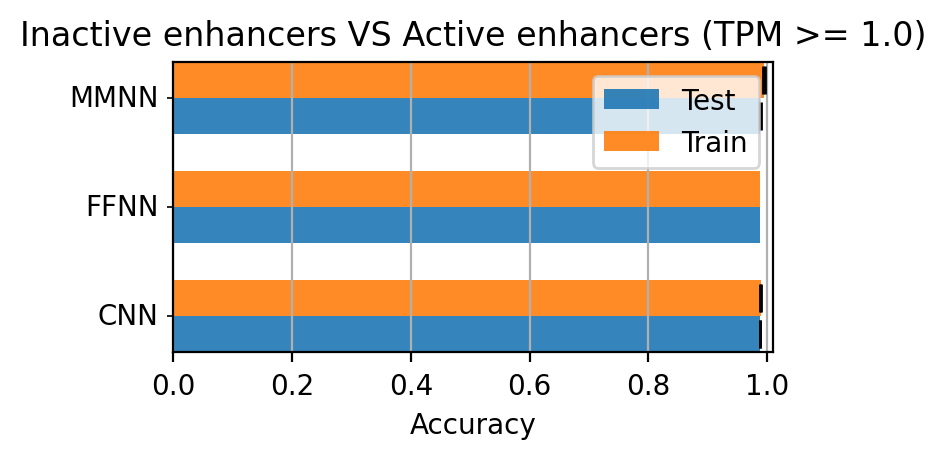

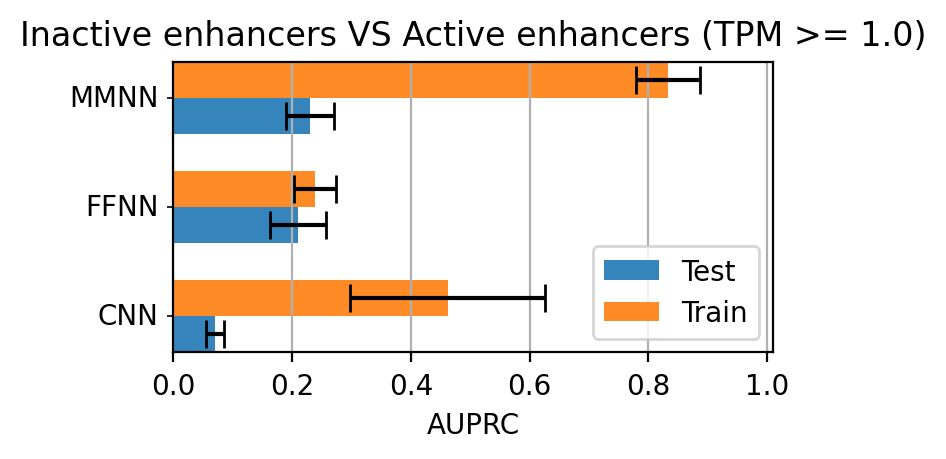

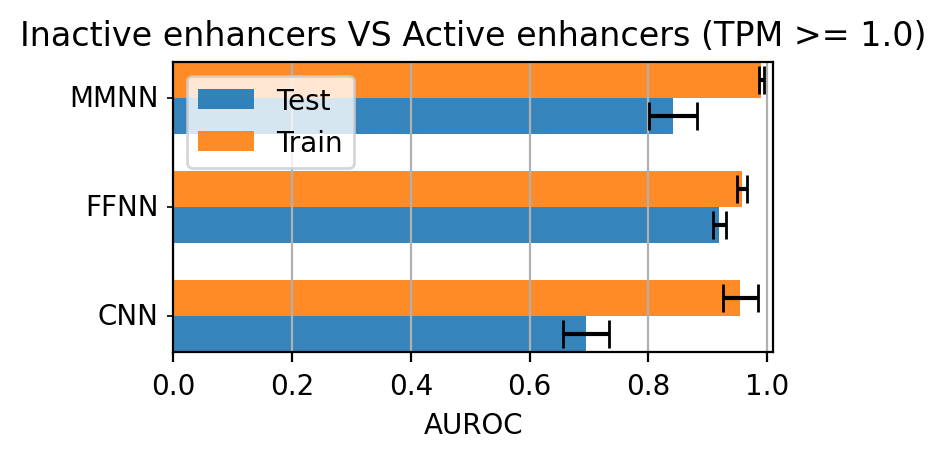

enhancers 0.5


accuracy     AUROC     AUPRC
model_name run_type                              
CNN        test      0.951948  0.662677  0.129634
           train     0.952052  0.861642  0.295690
FFNN       test      0.953804  0.802372  0.330261
           train     0.955094  0.816762  0.356714
MMNN       test      0.953812  0.791896  0.324694
           train     0.962232  0.840207  0.508014

The model FFNN is statistially indistinguishiable MMNN with p-value 0.6464622026641696 on metric AUPRC.
The model FFNN is statistially indistinguishiable MMNN with p-value 0.02841686417486375 on metric AUROC.
The model FFNN is statistially indistinguishiable MMNN with p-value 0.9593536340401635 on metric accuracy.
The model MMNN outperforms the model CNN with p-value 0.005062032126267864 on metric AUPRC.
The model MMNN outperforms the model CNN with p-value 0.005062032126267864 on metric AUROC.
The model MMNN outperforms the model CNN with p-value 0.005033508200606249 on metric accuracy.
The model FFNN outperforms the model CNN with p-value 0.005062032126267864 on metric AUPRC.
The model FFNN outperforms the model CNN with p-value 0.005062032126267864 on metric AUROC.
The model FFNN outperforms the model CNN with p-value 0.005062032126267864 on metric accuracy.
performance_enhancers_0.5.jpeg


Rendering barplots:   0%|          | 0/3 [00:00<?, ?it/s]

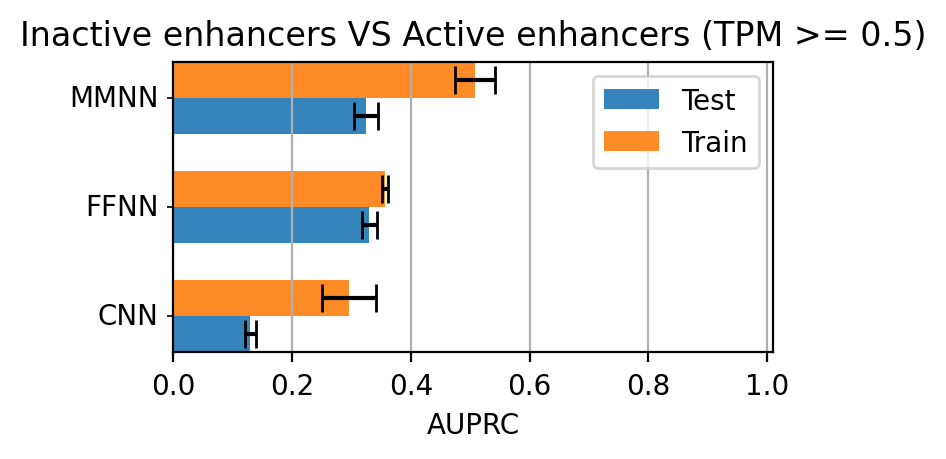

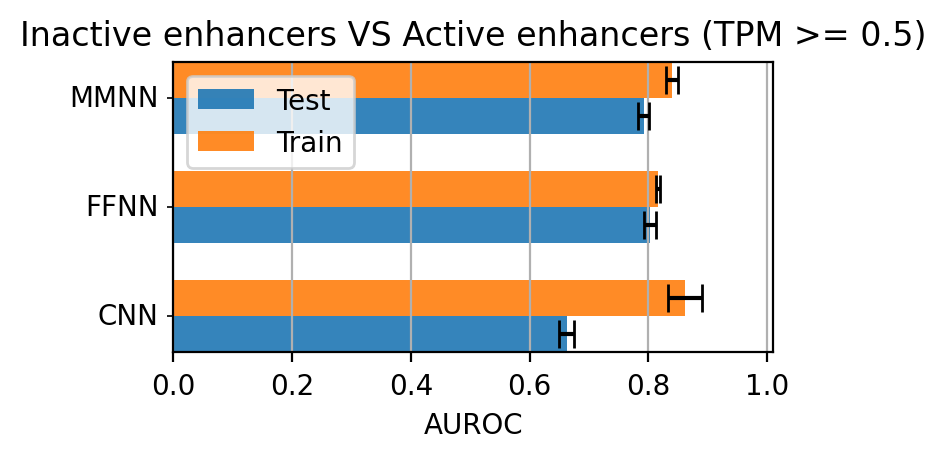

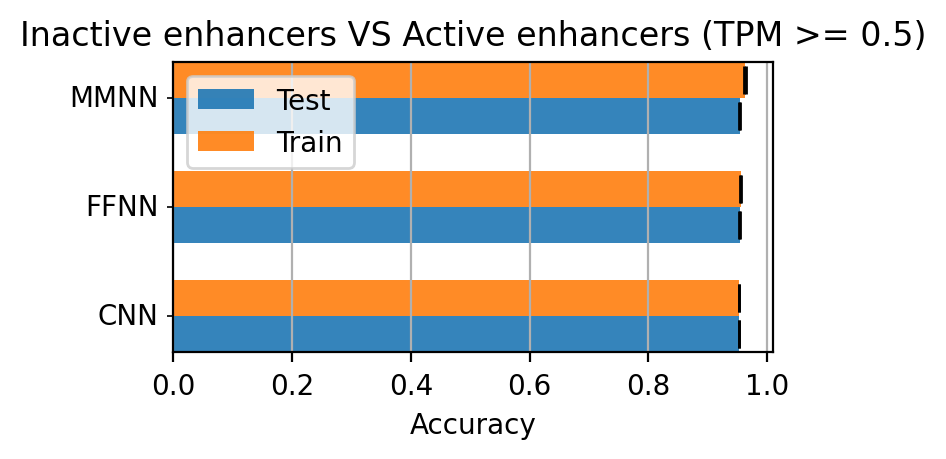

In [44]:
for element in all_performance_list:
  keys = list(element.keys())[0]
  print(keys[0], keys[1])
  all_performance = list(element.values())[0]
  display(all_performance.groupby(["model_name","run_type"]).mean())

  wilcoxon_test(all_performance)
    
  print(path_name)
  barplots(
      all_performance,
      groupby=["model_name", "run_type"],
      height=4,
      orientation = "horizontal",
      title = "Inactive "+keys[0]+ " vs Active "+keys[0]+" (TPM >= "+str(keys[1])+")"
  )
  
  plt.show()  
  
    

In [45]:
for dataset in dataset_list:
    print(dataset[0][0], dataset[0][1])
    all_performance_ffnn = pd.read_csv(f"{fold}//all_performances_{dataset[0][0]}_{dataset[0][1]}_ffnn.csv")
    all_performance_ffnn = all_performance_ffnn.rename(columns={'Accuracy': 'accuracy'})
    all_performance = all_performance_ffnn.filter(items=['model_name', 'run_type', 'accuracy', 'AUROC', 'AUPRC', 'use_feature_selection'])
    display(all_performance.groupby(["model_name","run_type",'use_feature_selection']).mean())

    

promoters 1.0


accuracy     AUROC     AUPRC
model_name run_type use_feature_selection                              
FFNN       test     False                  0.810207  0.858754  0.647538
                    True                   0.811874  0.859714  0.649052
           train    False                  0.828866  0.883889  0.713854
                    True                   0.827146  0.881035  0.707089

promoters 0.5


accuracy     AUROC     AUPRC
model_name run_type use_feature_selection                              
FFNN       test     False                  0.788517  0.852089  0.732688
                    True                   0.789133  0.852304  0.732424
           train    False                  0.799841  0.866175  0.771065
                    True                   0.800010  0.865848  0.769195

enhancers 1.0


accuracy     AUROC     AUPRC
model_name run_type use_feature_selection                              
FFNN       test     False                  0.988702  0.919148  0.209884
                    True                   0.988734  0.921916  0.216299
           train    False                  0.988702  0.957809  0.238087
                    True                   0.988791  0.955919  0.242802

enhancers 0.5


accuracy     AUROC     AUPRC
model_name run_type use_feature_selection                              
FFNN       test     False                  0.953804  0.802372  0.330261
                    True                   0.954010  0.803073  0.330197
           train    False                  0.955094  0.816762  0.356714
                    True                   0.954938  0.816013  0.355291